# Recurrent Neural Network
This file traines a recurrent neural network on the melspectogram features

In [25]:
import json
import yaml
from pathlib import Path
from lib_util import utils, plot


import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping 
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy

from keras.layers import (
    Input,
    GlobalAvgPool1D,
    Dense,
    Bidirectional,
    GRU,
    Dropout,
)
from keras.models import Model, load_model
from keras.optimizers import Adam

from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import clip_ops

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define crossentropy and accuracy metric for the training routine

For the metric we use a binary accuracy, for the loss a binary cross-entropy loss

# Define the model

define the RNN model structure 

In [26]:
def rnn_model(model_config, n_classes):
    """RNN model where the model will be trained on the training data
    """
    d_model = model_config['d_model']
    n_layers = model_config['n_layers']
    init_lr = model_config['init_learning_rate']
    dropout_rate = model_config['dropout_rate']
    activations = model_config['activations']
    dense_layer_class_ratio = model_config['dense_layer_class_ratio']
    inp = Input((None, d_model))
    #Bidirectional means having a neural network in both directions backwards
    x = Bidirectional(GRU(d_model, return_sequences=True))(inp)
    # Making different bidirectional layers 
    if n_classes > 1:
        for i in range(n_layers):
            x = Bidirectional(GRU(d_model, return_sequences=True))(x)

    x = Dropout(dropout_rate)(x)
    x = GlobalAvgPool1D()(x)
    x = Dense(dense_layer_class_ratio * n_classes, activation=activations[0])(x)
    out = Dense(n_classes, activation=activations[1])(x)
    model = Model(inputs=inp, outputs=out)

    loss = BinaryCrossentropy(
        name='binary_crossentropy'
    )
    
    metric = BinaryAccuracy(
        name='binary_accuracy'
    )
    
    model.compile(
        optimizer=Adam(init_lr), loss=loss, metrics=metric
    )

    model.summary()

    return model

# Main routine

Load the configuration for this model

In [27]:
config = utils.get_config('rnn')

# Extract the values
model_name = config['model_name']
batch_size = config['batch_size']
epochs = config['epochs']

# Load preprocessed data

Load the numpy arrays and the label-class mapping. Split the data accordingly into train, validation and test set

In [28]:
melspec_data = utils.load_sliced_numpy_array('melspec_features')
labels = np.load('data/labels.npy')

labels_to_id = utils.get_class_mapping()

mel_train, mel_test_val, lab_train, lab_test_val = train_test_split(melspec_data, labels, train_size=config['train_set_size'], random_state=config['random_state'])
mel_val, mel_test, lab_val, lab_test             = train_test_split(mel_test_val, lab_test_val, test_size=(config['val_set_size']/(1-config['train_set_size'])), shuffle=False)

# Check the shapes of the splitted sets
assert mel_train.shape[0] == lab_train.shape[0] and mel_test.shape[0] == lab_test.shape[0] and mel_val.shape[0] == lab_val.shape[0]
assert mel_train.shape[1] == mel_test.shape[1] == mel_val.shape[1] and lab_train.shape[1] == lab_test.shape[1] == lab_val.shape[1]

Load slice from file melspec_features_001.npy
Load slice from file melspec_features_002.npy
Load slice from file melspec_features_003.npy
Load slice from file melspec_features_004.npy
Load slice from file melspec_features_005.npy
Load slice from file melspec_features_006.npy
Load slice from file melspec_features_007.npy
Load slice from file melspec_features_008.npy
Load slice from file melspec_features_009.npy
Load slice from file melspec_features_010.npy
Load slice from file melspec_features_011.npy
Load slice from file melspec_features_012.npy
Loaded 12 files as slices, resulting shape: (4068, 33152)


# Set up the model callbacks

For initializing parameters, refer to the config file. For callbacks, we use a frequently backup of the model as checkpoints, and early stopping mechanism to prevent overfitting on the train data and a learning rate reducer. The learning rate reducer smallers the update step when the validation metric does not improve anymore

In [29]:
from pathlib import Path
train_config = config['training']

checkpoint = ModelCheckpoint(
    Path(config['output_dir'])/f'{model_name}_checkpoint',
    monitor=train_config['monitor'],
    verbose=1,
    save_best_only=train_config['save_best_weights'],
    mode=train_config['monitor_mode'],
    save_weights_only=False
)


es_config = config['training']['early_stopping']
early_stopping = EarlyStopping(
    monitor = es_config['monitor'],
    patience = es_config['patience'],
    verbose = 1,
    mode = es_config['mode'],
    restore_best_weights = True,
    start_from_epoch = es_config['start_from_epoch']
)

# Reduce learning rate when val_loss stopps improving
lr_reduce_config = train_config['lr_reducing']
lr_reducing_on_platteau = ReduceLROnPlateau(
    monitor=lr_reduce_config['monitor'], patience=lr_reduce_config['patience'], min_lr=lr_reduce_config['min_lr'], mode=lr_reduce_config['mode']
    )

# Train routine

In [30]:
# read in the config
pp_config = utils.get_config('preprocess')

n_mels = pp_config['melspectogram']['n_mels']
mel_train = mel_train.reshape(mel_train.shape[0], -1, n_mels)
mel_val   = mel_val.reshape(mel_val.shape[0], -1, n_mels)

model = rnn_model(config['model_structure'], n_classes=len(labels_to_id))

history = model.fit(
        x=mel_train,
        y=lab_train,
        validation_data=(mel_val, lab_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[checkpoint, lr_reducing_on_platteau, early_stopping],
        use_multiprocessing=True,
        verbose=2
    )


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 128)]       0         
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 256)        198144    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 256)        296448    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 256)        296448    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0         
                                                           

INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 122s - loss: 0.5015 - binary_accuracy: 0.7926 - val_loss: 0.4729 - val_binary_accuracy: 0.8000 - lr: 1.0000e-04 - 122s/epoch - 5s/step
Epoch 2/40

Epoch 2: val_loss improved from 0.47291 to 0.45287, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 91s - loss: 0.4594 - binary_accuracy: 0.8020 - val_loss: 0.4529 - val_binary_accuracy: 0.8039 - lr: 1.0000e-04 - 91s/epoch - 4s/step
Epoch 3/40

Epoch 3: val_loss improved from 0.45287 to 0.43281, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 92s - loss: 0.4364 - binary_accuracy: 0.8110 - val_loss: 0.4328 - val_binary_accuracy: 0.8085 - lr: 1.0000e-04 - 92s/epoch - 4s/step
Epoch 4/40

Epoch 4: val_loss improved from 0.43281 to 0.41383, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 94s - loss: 0.4145 - binary_accuracy: 0.8204 - val_loss: 0.4138 - val_binary_accuracy: 0.8193 - lr: 1.0000e-04 - 94s/epoch - 4s/step
Epoch 5/40

Epoch 5: val_loss improved from 0.41383 to 0.39818, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 89s - loss: 0.3888 - binary_accuracy: 0.8334 - val_loss: 0.3982 - val_binary_accuracy: 0.8269 - lr: 1.0000e-04 - 89s/epoch - 4s/step
Epoch 6/40

Epoch 6: val_loss improved from 0.39818 to 0.38659, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 89s - loss: 0.3683 - binary_accuracy: 0.8422 - val_loss: 0.3866 - val_binary_accuracy: 0.8344 - lr: 1.0000e-04 - 89s/epoch - 4s/step
Epoch 7/40

Epoch 7: val_loss improved from 0.38659 to 0.37668, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 95s - loss: 0.3501 - binary_accuracy: 0.8560 - val_loss: 0.3767 - val_binary_accuracy: 0.8311 - lr: 1.0000e-04 - 95s/epoch - 4s/step
Epoch 8/40

Epoch 8: val_loss improved from 0.37668 to 0.36486, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 93s - loss: 0.3335 - binary_accuracy: 0.8594 - val_loss: 0.3649 - val_binary_accuracy: 0.8433 - lr: 1.0000e-04 - 93s/epoch - 4s/step
Epoch 9/40

Epoch 9: val_loss improved from 0.36486 to 0.36261, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 89s - loss: 0.3169 - binary_accuracy: 0.8709 - val_loss: 0.3626 - val_binary_accuracy: 0.8439 - lr: 1.0000e-04 - 89s/epoch - 4s/step
Epoch 10/40

Epoch 10: val_loss improved from 0.36261 to 0.35527, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 96s - loss: 0.3041 - binary_accuracy: 0.8761 - val_loss: 0.3553 - val_binary_accuracy: 0.8482 - lr: 1.0000e-04 - 96s/epoch - 4s/step
Epoch 11/40

Epoch 11: val_loss did not improve from 0.35527
23/23 - 61s - loss: 0.2924 - binary_accuracy: 0.8815 - val_loss: 0.3566 - val_binary_accuracy: 0.8446 - lr: 1.0000e-04 - 61s/epoch - 3s/step
Epoch 12/40

Epoch 12: val_loss improved from 0.35527 to 0.34429, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 88s - loss: 0.2850 - binary_accuracy: 0.8868 - val_loss: 0.3443 - val_binary_accuracy: 0.8498 - lr: 1.0000e-04 - 88s/epoch - 4s/step
Epoch 13/40

Epoch 13: val_loss improved from 0.34429 to 0.34315, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 93s - loss: 0.2701 - binary_accuracy: 0.8941 - val_loss: 0.3432 - val_binary_accuracy: 0.8570 - lr: 1.0000e-04 - 93s/epoch - 4s/step
Epoch 14/40

Epoch 14: val_loss did not improve from 0.34315
23/23 - 60s - loss: 0.2589 - binary_accuracy: 0.8970 - val_loss: 0.3563 - val_binary_accuracy: 0.8521 - lr: 1.0000e-04 - 60s/epoch - 3s/step
Epoch 15/40

Epoch 15: val_loss improved from 0.34315 to 0.33578, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 86s - loss: 0.2500 - binary_accuracy: 0.9026 - val_loss: 0.3358 - val_binary_accuracy: 0.8613 - lr: 1.0000e-04 - 86s/epoch - 4s/step
Epoch 16/40

Epoch 16: val_loss did not improve from 0.33578
23/23 - 57s - loss: 0.2370 - binary_accuracy: 0.9089 - val_loss: 0.3475 - val_binary_accuracy: 0.8525 - lr: 1.0000e-04 - 57s/epoch - 2s/step
Epoch 17/40

Epoch 17: val_loss did not improve from 0.33578
23/23 - 59s - loss: 0.2293 - binary_accuracy: 0.9130 - val_loss: 0.3472 - val_binary_accuracy: 0.8577 - lr: 1.0000e-04 - 59s/epoch - 3s/step
Epoch 18/40

Epoch 18: val_loss did not improve from 0.33578
23/23 - 61s - loss: 0.2206 - binary_accuracy: 0.9165 - val_loss: 0.3372 - val_binary_accuracy: 0.8593 - lr: 1.0000e-04 - 61s/epoch - 3s/step
Epoch 19/40

Epoch 19: val_loss improved from 0.33578 to 0.33200, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 90s - loss: 0.2025 - binary_accuracy: 0.9255 - val_loss: 0.3320 - val_binary_accuracy: 0.8610 - lr: 1.0000e-05 - 90s/epoch - 4s/step
Epoch 20/40

Epoch 20: val_loss did not improve from 0.33200
23/23 - 58s - loss: 0.1997 - binary_accuracy: 0.9262 - val_loss: 0.3329 - val_binary_accuracy: 0.8620 - lr: 1.0000e-05 - 58s/epoch - 3s/step
Epoch 21/40

Epoch 21: val_loss did not improve from 0.33200
23/23 - 61s - loss: 0.1984 - binary_accuracy: 0.9274 - val_loss: 0.3353 - val_binary_accuracy: 0.8623 - lr: 1.0000e-05 - 61s/epoch - 3s/step
Epoch 22/40

Epoch 22: val_loss did not improve from 0.33200
23/23 - 65s - loss: 0.1970 - binary_accuracy: 0.9286 - val_loss: 0.3370 - val_binary_accuracy: 0.8620 - lr: 1.0000e-05 - 65s/epoch - 3s/step
Epoch 23/40

Epoch 23: val_loss did not improve from 0.33200
23/23 - 65s - loss: 0.1957 - binary_accuracy: 0.9284 - val_loss: 0.3337 - val_binary_accuracy: 0.8616 - lr: 1.0000e-06 - 65s/epoch - 3s/step
Epoch 24/40

Epoch 24: val_loss improved from 0.332

INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 92s - loss: 0.1945 - binary_accuracy: 0.9290 - val_loss: 0.3316 - val_binary_accuracy: 0.8620 - lr: 1.0000e-06 - 92s/epoch - 4s/step
Epoch 25/40

Epoch 25: val_loss improved from 0.33164 to 0.33124, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 93s - loss: 0.1945 - binary_accuracy: 0.9299 - val_loss: 0.3312 - val_binary_accuracy: 0.8623 - lr: 1.0000e-06 - 93s/epoch - 4s/step
Epoch 26/40

Epoch 26: val_loss did not improve from 0.33124
23/23 - 58s - loss: 0.1943 - binary_accuracy: 0.9301 - val_loss: 0.3314 - val_binary_accuracy: 0.8633 - lr: 1.0000e-06 - 58s/epoch - 3s/step
Epoch 27/40

Epoch 27: val_loss did not improve from 0.33124
23/23 - 61s - loss: 0.1941 - binary_accuracy: 0.9296 - val_loss: 0.3319 - val_binary_accuracy: 0.8623 - lr: 1.0000e-06 - 61s/epoch - 3s/step
Epoch 28/40

Epoch 28: val_loss did not improve from 0.33124
23/23 - 62s - loss: 0.1940 - binary_accuracy: 0.9295 - val_loss: 0.3315 - val_binary_accuracy: 0.8623 - lr: 1.0000e-06 - 62s/epoch - 3s/step
Epoch 29/40

Epoch 29: val_loss did not improve from 0.33124
23/23 - 64s - loss: 0.1938 - binary_accuracy: 0.9295 - val_loss: 0.3315 - val_binary_accuracy: 0.8623 - lr: 1.0000e-07 - 64s/epoch - 3s/step
Epoch 30/40

Epoch 30: val_loss did not improve fro

In [33]:
from lib_util import utils

to_dump = {
    'model': model,
    'history': history.history,
    'config': config
}

utils.save_training(to_dump, model_name, dir=config['output_dir'])

INFO:tensorflow:Assets written to: models/rnn/rnn_trained/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_trained/assets


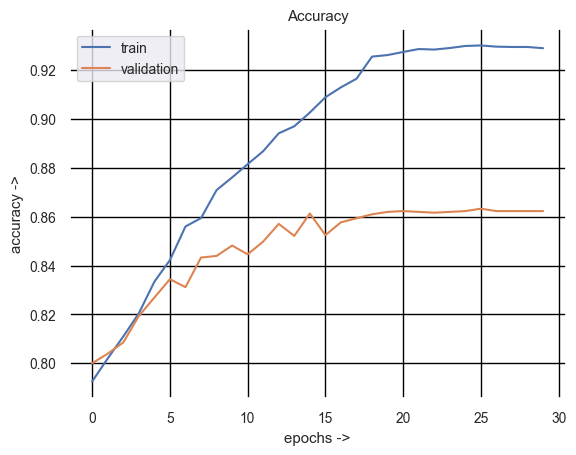

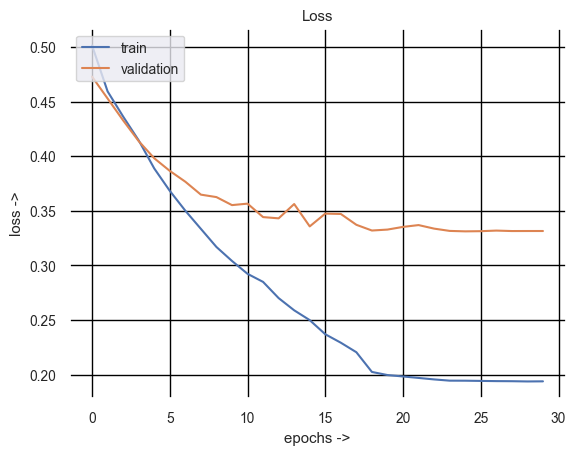

In [35]:
history = utils.load_history(model_name, dir=config['output_dir'])
model_name = config['model_name']

#Plots for the accuracies and losses of the train and validation data per epoch
plot.plot_hist(history, ('binary_accuracy', 'val_binary_accuracy'), legends=('train', 'validation'), title='Accuracy', y_label='accuracy ->', x_label='epochs ->', save_to=f'Plots/{model_name}_{epochs}_accuracy')
plot.plot_hist(history, ('loss', 'val_loss'), legends=('train', 'validation'), title='Loss', y_label='loss ->', x_label='epochs ->', save_to=f'Plots/{model_name}_{epochs}_loss')

In [36]:
predict = lambda model, data: np.argmax(model.predict(data), axis=-1)

mel_test = mel_test.reshape(mel_test.shape[0], -1, n_mels)

#Loading in the model
model = utils.load_model(model_name, dir=config['output_dir'])

# Training prediction
y_pred_train = predict(model, mel_train)
y_true_train = np.argmax(lab_train, axis= -1)
print(f"ACCURACY FOR TRAIN SET {accuracy_score(y_true_train, y_pred_train)*100:.4f} %")
print(f"MACRO F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='micro')*100:.4f} %")
print(f"WEIGHTED F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='weighted')*100:.4f} %")


# Validation prediction
y_pred_val = predict(model, mel_val)
y_true_val = np.argmax(lab_val, axis= -1)
print(f"ACCURACY FOR VAL SET {accuracy_score(y_true_val, y_pred_val)*100:.4f} %")
print(f"MACRO F1 SCORE FOR VAL SET {f1_score(y_true_val, y_pred_val, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR VAL SET {f1_score(y_true_val, y_pred_val, average='micro')*100:.4f} %")
print(f"WEIGHTED F1 SCORE FOR TRAIN SET {f1_score(y_true_val, y_pred_val, average='weighted')*100:.4f} %")


# Test prediction
y_pred_test = predict(model, mel_test)
y_true_test = np.argmax(lab_test, axis= -1)
print(f"ACCURACY FOR TEST SET {accuracy_score(y_true_test, y_pred_test)*100:.4f} %")
print(f"MACRO F1 SCORE FOR TEST SET {f1_score(y_true_test, y_pred_test, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR TEST SET {f1_score(y_true_test, y_pred_test, average='micro')*100:.4f} %")
print(f"WEIGHTED F1 SCORE FOR TEST SET {f1_score(y_true_test, y_pred_test, average='weighted')*100:.4f} %")

89/89 [==============================] - 22s 223ms/step
ACCURACY FOR TRAIN SET 83.6670 %
MACRO F1 SCORE FOR TRAIN SET 81.9216 %
MICRO F1 SCORE FOR TRAIN SET 83.6670 %
WEIGHTED F1 SCORE FOR TRAIN SET 83.3228 %
20/20 [==============================] - 4s 209ms/step
ACCURACY FOR VAL SET 62.9508 %
MACRO F1 SCORE FOR VAL SET 60.4192 %
MICRO F1 SCORE FOR VAL SET 62.9508 %
WEIGHTED F1 SCORE FOR TRAIN SET 62.2888 %
20/20 [==============================] - 4s 211ms/step
ACCURACY FOR TEST SET 66.9394 %
MACRO F1 SCORE FOR TEST SET 63.4214 %
MICRO F1 SCORE FOR TEST SET 66.9394 %
WEIGHTED F1 SCORE FOR TEST SET 66.2035 %


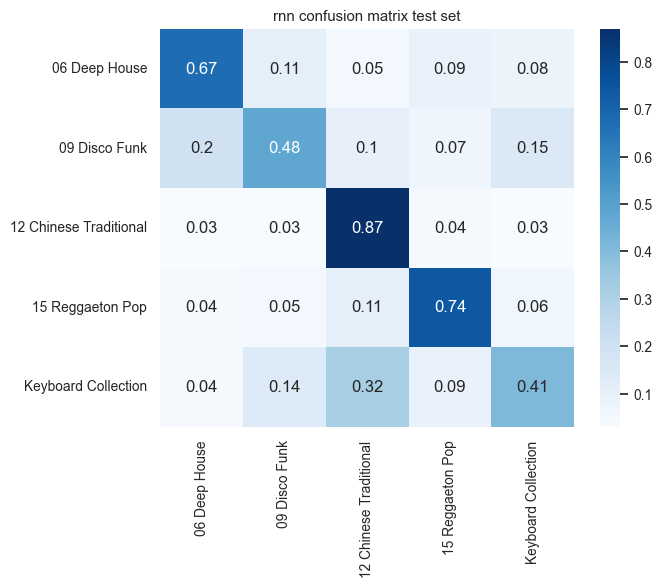

In [37]:
class_names = utils.get_class_names()

#Confusion matrix of the predicted labels versus the true labels
conf_mat = confusion_matrix(y_true_test, y_pred_test, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = pd.DataFrame(conf_mat, columns=class_names, index=class_names)

plot.plot_conf_mat(conf_mat_df, save_to=f"Plots/{model_name}_{epochs}_test_conf_mat.png", name=model_name, set_type='test')